In [2]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow
import numpy as np
import tensorflow as tf
import keras
import os
from tqdm import tqdm_notebook as tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/natural_images.zip (Unzipped Files)/natural_images'

train_datagen = ImageDataGenerator(rescale=1./ 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=16, class_mode = None, classes = ['flower'])

Found 843 images belonging to 1 classes.


In [5]:
print(len(train))

53


In [6]:
X =[]
Y =[]
 
for i in tqdm(range(53)):
  for img in train[i]:
    try:
      lab = rgb2lab(img)
      X.append(lab[:, :, 0]) 
      Y.append(lab[:, :, 1:] / 128) #A and B values range from -127 to 128, 
      
    except:
      print('error')
X = np.array(X)
Y = np.array(Y)
print(X.shape)
X = X.reshape(X.shape+(1,)) #same dimensions for x and y
print(X.shape)
print(Y.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



(843, 224, 224)
(843, 224, 224, 1)
(843, 224, 224, 2)


In [7]:
from keras.applications.vgg16 import VGG16    #for features
vggmodel = VGG16()
newmodel = Sequential() 
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   

553467904/553467096 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_______________________________________________________

In [8]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1, 224, 224, 3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)



#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

(843, 7, 7, 512)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 5

In [10]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=100, batch_size=16)

Epoch 1/100
53/53 [==============================] - 31s 574ms/step - loss: 0.0271 - accuracy: 0.7498
Epoch 2/100
53/53 [==============================] - 30s 564ms/step - loss: 0.0202 - accuracy: 0.7883
Epoch 3/100
53/53 [==============================] - 30s 562ms/step - loss: 0.0193 - accuracy: 0.7966
Epoch 4/100
53/53 [==============================] - 30s 566ms/step - loss: 0.0180 - accuracy: 0.8058
Epoch 5/100
53/53 [==============================] - 30s 564ms/step - loss: 0.0167 - accuracy: 0.8121
Epoch 6/100
53/53 [==============================] - 30s 573ms/step - loss: 0.0168 - accuracy: 0.8059
Epoch 7/100
53/53 [==============================] - 31s 584ms/step - loss: 0.0165 - accuracy: 0.8109
Epoch 8/100
53/53 [==============================] - 31s 582ms/step - loss: 0.0159 - accuracy: 0.8157
Epoch 9/100
53/53 [==============================] - 31s 579ms/step - loss: 0.0155 - accuracy: 0.8256
Epoch 10/100
53/53 [==============================] - 31s 591ms/step - loss: 0.014

In [24]:
!mkdir -p saved_models_flowers

In [25]:
newmodel.save('saved_models_flowers/encoder.model')
model.save('saved_models_flowers/decoder.model')


INFO:tensorflow:Assets written to: saved_models_flowers/encoder.model/assets
INFO:tensorflow:Assets written to: saved_models_flowers/decoder.model/assets


In [ ]:
model = tf.keras.models.load_model('saved_models_flowers.model', custom_objects=None, compile=True)

In [22]:
from google.colab import files
files.upload()

Saving lily.jpg to lily.jpg


{'lily.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x01\xf1\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x05\x06\x01\x07\x08\xff\xc4\x00\x14\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf9P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x002\xf7G4\xec`r-\xc6\xa4\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 184 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


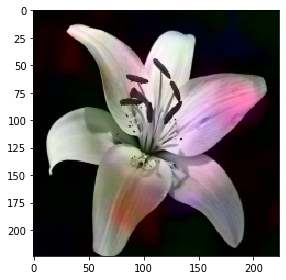

In [23]:
file = 'lily.jpg'
test = img_to_array(load_img(file))
test = resize(test, (224, 224), anti_aliasing=True)
test*= 1.0 / 255
lab = rgb2lab(test)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1, 224, 224, 3))
vggpred = newmodel.predict(L)
#print(vggpred)
ab = model.predict(vggpred)
ab = ab * 128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
imshow(lab2rgb(cur))